# Model of heavy alcohol consumption among high school students

This section of the analysis will attempt to construct a model to predict:

* heavy_drinker - a higher level (4-5) of weekend alcohol consumption accompanied by a high level (4-5) of weekday alcohol consumption.
* Walc - level of workday alcohol consumption
* Dalc - level of weekend alcohol consumption

<a id="executive_summary"></a>
# Executive Summary
The target class was highly unbalanced with the positive class (heavy drinkers) making up less than 5% of the population. For this reason, recall was chosen as the performance metric rather than accuracy. That is, performance should be weighted towards identifying heavy drinkers even if it means incorrectly classifying some normal drinkers as heavy drinkers.

The most effective model proved to be a Principle Component Analysis reducing the 50 feature space to a single feature and achieving impressive recall in finding the heavy drinkers. The dimension appeared to be related to the student's academic achievement

Unfortunately, both simple (Logistic Regression) and complex (Gradient Boosted Decision Tree with GridSearchCV) showed only trivial recall improvement (if any) over a Stratified Dummy Classifier.

Recall of the heavy drinkers proved to be difficult as they were uniformly distributed among the normal drinkers ([swarm plot](#a_telling_swarm)).

# Uninteresting Helper Code
[Fast forward to the meat](#reading_in_file)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.ticker as ticker

from IPython.core.debugger import set_trace #https://docs.python.org/3/library/pdb.html

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, PowerTransformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import roc_curve, auc, confusion_matrix
%matplotlib inline 
#to allow plots to render in the notebook

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18})

In [10]:
class AlcoholStudyDataPreparer:
    
    def __init__(self):
        
        pass
    
    def read_in_data_from(self, path):
        self.data= pd.read_csv(path)
        
    def data_length_checker(self):
        print("There are ", str(self.data.shape[1]), " columns in the data")
        
    def move_alcohol_related_variables_to_end_of_column_list(self, data):
        self.data = data
        self.data_length_checker()
        print("Moving alcohol related variables to the end of the list")
        alcohol_related_variables = ["binge_drinker", "heavy_drinker", "Dalc", "Walc"]
        cols = self.data.columns.tolist()
        cols = set(cols) - set(alcohol_related_variables) - set(["Unnamed: 0"])
        cols = list(cols) + alcohol_related_variables
        self.data = data[cols]
        self.data_length_checker()
        
    def ready_data_for_experiments(self, path):
        self.read_in_data_from(path)
        self.move_alcohol_related_variables_to_end_of_column_list(self.data)
        print(self.data.shape)
        return self
    
    def plot_dependent_variable(self):
        data = self.data
        f, ax = plt.subplots(1,1)
        sns.countplot("heavy_drinker", data=data, ax=ax)
        f.suptitle("Distribution of heavy drinkers")
        print(data.groupby(data["heavy_drinker"])["heavy_drinker"].count())
        
class Experiment:
    
    def __init__(self):
        
        pass
    
    def run_experiment(self, data, y_col_name, estimator, evaluation):
        self.data = data
        model = ModelFitter(data)
        self.X_train, self.X_test, self.y_train, self.y_test = model.get_test_train_splits(y_col_name)
        fit_model = model.fit_model_and_evaluate(estimator, evaluation)
        Evaluation().plot_learning_curve(self.data, estimator)
        return fit_model
        
    
class ModelFitter:
    
    def __init__(self, data):
        self.data = data
        pass
    
    def separate_X_from_y(self, y_col_name):
        self.X = self.data.iloc[:, :-4]
        self.y = self.data.loc[:, y_col_name].values.reshape(-1, )
        return self.X, self.y
    
    def divide_into_training_and_test(self, train_size):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, random_state=0, train_size=train_size, test_size=(1-train_size)
        )
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def get_test_train_splits(self, y_col_name, train_size=0.7):
        self.separate_X_from_y(y_col_name)
        return self.divide_into_training_and_test(train_size)
    
    def fit_model(self, estimator, X_train, y_train):
        self.model = estimator(X_train, y_train)
        fit_model = self.model.fit(X_train, y_train)
        return fit_model
    
    def fit_model_and_evaluate(self, estimator, evaluation):
        fitted_model = self.fit_model(estimator, self.X_train, self.y_train)
        evaluation(fitted_model, self)
        return fitted_model
    
class Evaluation:
    
    def print_accuracy_score(self, model, data):
        print("Accuracy is: " + str(model.score(data.X_train, data.y_train)))
        
    def print_confusion_matrix(self, model, data, figsize=(20,8), fontsize=14, model_name=""):
        #tweaked from shyapal5 https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
        class_names = ["normal_drinker", "heavy_drinker"]
        
        f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=figsize)
        
        def __create_single_heatmap(X, y, name, ax):
            y_pred = model.predict(X)
            conf_matrix = confusion_matrix(y, y_pred)
            df_cm = pd.DataFrame(
                conf_matrix, index=class_names, columns=class_names
            )
            try:
                heatmap = sns.heatmap(df_cm, annot=True, fmt="d", ax=ax)
            except ValueError:
                raise ValueError("Confusion matrix values must be integers")
            heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
            heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
            heatmap.set_title(("Confusion matrix for " + name + " set"))
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            
        __create_single_heatmap(data.X_train, data.y_train, "train", ax1)
        __create_single_heatmap(data.X_test, data.y_test, "test", ax2)
    
    def __compute_auc(self, y, y_pred):
        fpr, tpr, thresholds = roc_curve(y, y_pred)
        return auc(fpr, tpr)
    
    def __compute_confusion_matrix(self, y, y_pred):
        return confusion_matrix(y, y_pred)
    
    def __calculate_metric(self, fitted_model, X, y):
        y_pred = fitted_model.predict(X)
        return self.metric(self, y, y_pred) #if I were passing in a custom metric, would it be tricky to pass in the Evaluation in stance from the caller?
        
    def __get_train_and_test_metric_for_train_size(self, train_size):
        model = ModelFitter(self.data)
        #TODO: find a way to get rid of this magic string
        self.X_train, self.X_test, self.y_train, self.y_test = model.get_test_train_splits("heavy_drinker", train_size)
        fitted_model = model.fit_model(self.estimator, self.X_train, self.y_train)
        train_metric = self.__calculate_metric(fitted_model, self.X_train, self.y_train)
        test_metric = self.__calculate_metric(fitted_model, self.X_test, self.y_test)
        return (train_size, train_metric, test_metric)
    
    def __get_learning_curve_data(self):
        metrics = [self.__get_train_and_test_metric_for_train_size(train_size) for train_size in self.train_sizes]
        train_df = pd.DataFrame(data=[(metric[0], metric[1], "train") for metric in metrics])
        test_df = pd.DataFrame(data=[(metric[0], metric[2], "test") for metric in metrics])        
        metrics = pd.concat([train_df, test_df])
        metrics.columns = ["train_size", "auc", "split"]

        return metrics
    
    def plot_learning_curve(self, data, estimator, train_sizes=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9], metric=__compute_auc):
        
        #plots the learning_curves
        self.metric = metric
        self.data = data
        self.train_sizes = train_sizes
        self.estimator = estimator
        lc_data = self.__get_learning_curve_data()
        fig, ax = plt.subplots(1,1)
        fig.suptitle("Learning Curve")
        sns.pointplot("train_size", "auc", hue="split", data=lc_data, ax=ax)
        return lc_data

class PCAInvestigator:
    
    def __init__(self, pca, data):
        self.pca = pca
        self.data = data
        self.create_pca_df()
        self.transformed = self.transform_to_pca_components()
        pass

    def create_pca_df(self):
        components = self.pca.components_
        self.component_labels = [("PCA" + str(i+1)) for i, val in enumerate(components)]
        df = pd.DataFrame(data=components, columns=self.data.X_train.columns).transpose()
        df.columns = self.component_labels
        self.df = df
        return df
    
    def get_n_largest_features_for_component(self, component_name, n):
        
        abs_col = str(component_name + "_abs")
        self.df[abs_col] = self.df[component_name].abs() #for ranking purposes, we need the absolute value of the coeff
        components = self.df.nlargest(n, abs_col)[[component_name, abs_col]]
        df = pd.DataFrame(data=components).reset_index() #unhooks the feature names from the index
        df["rank"] = df[abs_col].rank(ascending=False)
        df = df.loc[:, ["index", component_name, "rank"]] #after we have rank, we no longer need abs_col
        df.columns=["feature_name", "variance_explained", "rank"]
        return #df.set_index("rank")
    
    def get_n_largest_features_for_pca(self, n):

        n_largest_features = [self.get_n_largest_features_for_component(label, n) for label in self.component_labels]
        #pretty much nothing for here below is robust to situations where pca components > 2
        print(n_largest_features[0])
        if len(n_largest_features) > 1:
            df = pd.merge(n_largest_features[0], n_largest_features[1], on="rank", suffixes=("_PCA1", "_PCA2"))
            df = df.set_index("rank")
            self.largest_features_per_factor = df
        else:
            self.largest_features_per_factor = n_largest_features[0]
        return self.largest_features_per_factor
    
    def transform_to_pca_components(self):
        
        pca_results = self.pca.transform(self.data.X_train)
        pca_results = pd.DataFrame(data=pca_results)
        pca_results.columns = self.component_labels
        pca_results["heavy_drinker"] = self.data.y_train
        return pca_results
    
    def plot_pca_components(self):
        
        f, ax = plt.subplots(1,1, figsize = (10,7))
        f.suptitle("Heavy Drinker instances across PCA1 vs PCA2")
        sns.scatterplot("PCA1", "PCA2", hue="heavy_drinker", data=self.transformed);
        
    def plot_pca_component(self):
        
        f, ax = plt.subplots(1,1, figsize = (10,7))
        f.suptitle("Distribution of heavy drinkers across PCA1")
        sns.swarmplot(x="heavy_drinker", y="PCA1", data=self.transformed);
        
pca_investigation = PCAInvestigator(logit_grid.best_estimator_.steps[1][1], exp2)
pca_investigation.get_n_largest_features_for_pca(10)

None


ValueError: can not merge DataFrame with instance of type <class 'NoneType'>

<a id="reading_in_file"></a>
# Reading in file and checking columns

In [3]:
asdp = AlcoholStudyDataPreparer().ready_data_for_experiments('../input/student_math_por_formatted.csv')

There are  51  columns in the data
Moving alcohol related variables to the end of the list
There are  50  columns in the data
(1044, 50)


# Metric Selection

heavy_drinker
0.0    1002
1.0      42
Name: heavy_drinker, dtype: int64


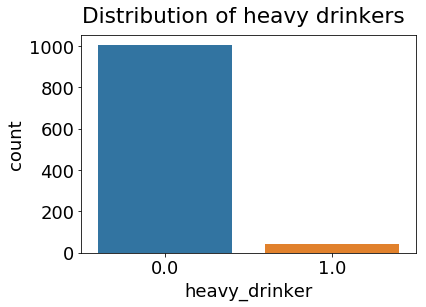

In [4]:
asdp.plot_dependent_variable()

The figure above shows that the classes are imbalanced; accuracy may not be a suitable measure.

Take, for example, an accuracy of 95%. Since the heavy drinkers make up less than 5% of the sample, a classifier could fail to detect all of the heavy drinkers in the sample and still achieve a 95% accuracy.

Effectiveness of this model would be finding all the heavy drinkers so that they can be targeted for any interventions.

# Modelling
## Baseline performance: Stratified Dummy Classifier

accuracy score: 0.923566878981


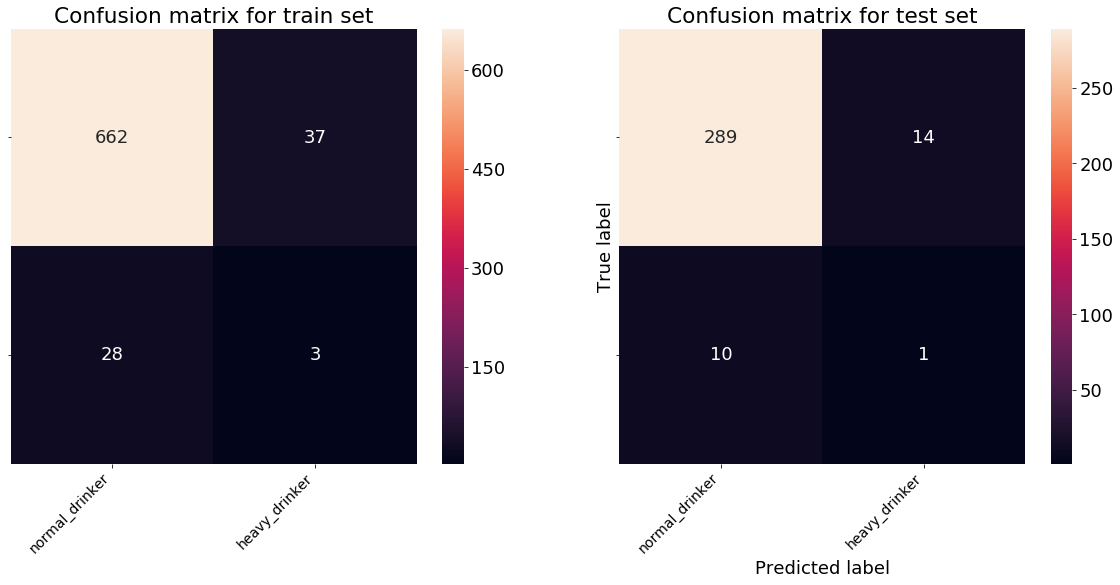

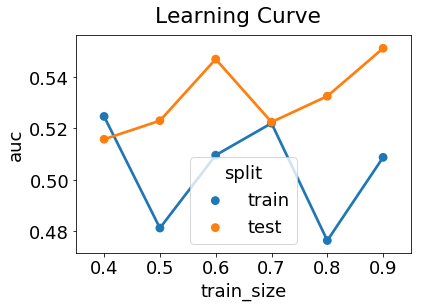

In [5]:
#exp1_classifier = DummyClassifier(strategy="stratified", random_state=0)
def exp1_classifier(X_train, y_train):
    return DummyClassifier(strategy="stratified", random_state=0)

exp1_eval = Evaluation().print_confusion_matrix
exp1 = Experiment()
dummy = exp1.run_experiment(asdp.data, "heavy_drinker", exp1_classifier,exp1_eval)
print("accuracy score: " + str(dummy.score(exp1.X_test, exp1.y_test)))

### Lots of room for improvement
The results above illustrate the point exactly. The accuracy score is 93%. However, as can be seen from the confusion matrix, only one heavy_drinker was predicted correctly. What's worse, nine normal drinkers were incorrectly classified as heavy drinkers and nine heavy drinkers were incorrectly classified as normal drinkers.

A dummy classifier is meant to give us only a baseline of the predictive power. Hopefully, things will only improve from here!

## Logistic Regression Approach
### Preprocessing
1. Remove collinearity by applying PCA.
2. Investigate factors for linear relationship with heavy_drinker variable.
3. Apply transformations as required to remove outliers

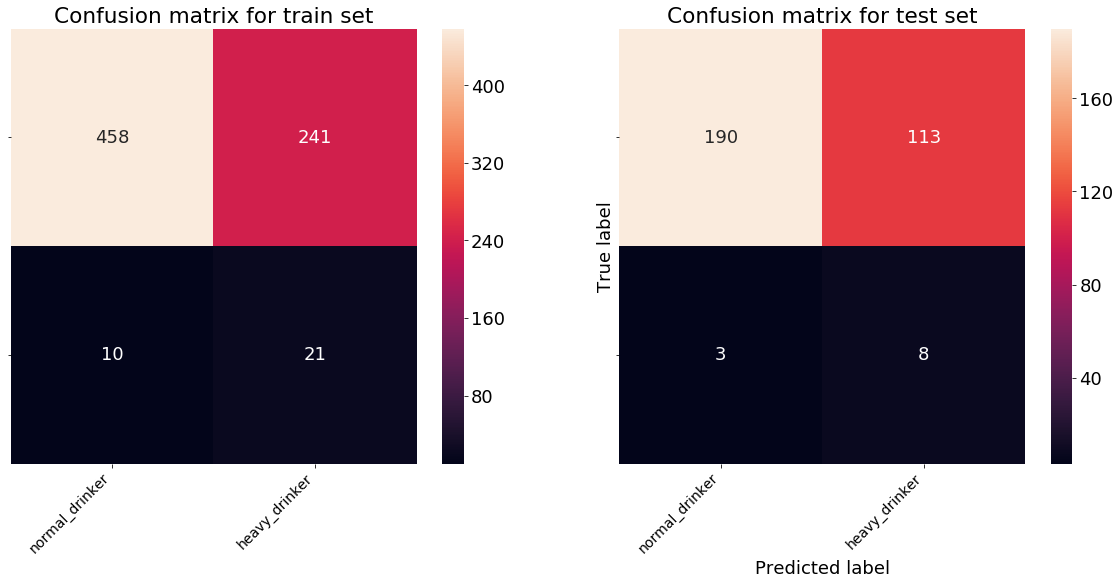

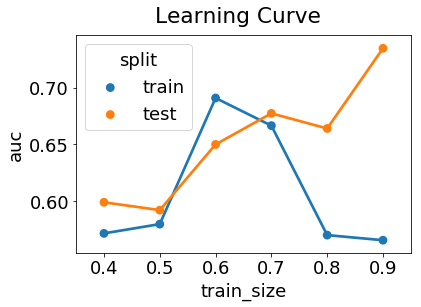

In [6]:
def exp2_classifier(X_train, y_train):
    
    estimators = [('robust_scaler', RobustScaler()), 
                  ('reduce_dim', PCA(random_state=0)), 
                  ('normalise_pca', PowerTransformer()), #I applied this as the distribution of the PCA factors were skew
                  ('clf', LogisticRegression(random_state=0, solver="liblinear"))] 
                #solver specified here to suppress warnings, it doesn't seem to effect gridSearch
    pipe = Pipeline(estimators)
    pipe.fit(X_train, y_train)
    
    param_grid = dict(reduce_dim__n_components=[1, 2, 3, 4, 5, 10],
                    clf__solver=["liblinear", "lbfgs"],
                     clf__class_weight=["balanced", None])
    return GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring="recall", iid=False)

exp2_eval = Evaluation().print_confusion_matrix
exp2 = Experiment()
logit_grid = exp2.run_experiment(asdp.data, "heavy_drinker", exp2_classifier, exp2_eval);

#TODO: link this kernel here: https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search#354172

The logistic regression appears promising. 

The next section will take a closer look at the results of the dimensionality reduction that was fed to the model.

#### Dimensionality Reduction Analysis: Something like academic performance

In [7]:
pca_investigation = PCAInvestigator(logit_grid.best_estimator_.steps[1][1], exp2)
pca_investigation.get_n_largest_features_for_pca(10)

KeyError: 'rank'

The grid search cross validation ended up collapsing most of the variables to a single factor. From the highest rank variables above, it appears to be related to academic achievement (grades, failures, studytime).

It's a bit of a strange result given that the performance of the GridSearchCV is optimised for recall.
<a id="a_telling_swarm"></a>
From the plot below, it is a surprise that the model was able to pick the heavy drinkers from the crowd: The single factor coming out of the PCA shows the heavy drinkers somewhat evenly distributed among the normal drinkers. It should be noted, however, in the test set, 107 normal drinkers were classified as heavy drinkers.

[back to executive summary](#executive_summary)


In [ ]:
pca_investigation.plot_pca_component()

It seems unlikely that any of the simpler models like LDA or Linear SVM will be able to separate the classes. Thus, the more complex models will be used, even though some interpetability will be sacrificed.
## Gradient Boosted Decision Trees
### Using the same pipe / GridSearch params (where applicable)

In [ ]:
def exp3_classifier(X_train, y_train):
    
    estimators = [('robust_scaler', RobustScaler()), 
                  ('reduce_dim', PCA(random_state=0)), 
                  ('normalise_pca', PowerTransformer()), #I applied this as the distribution of the PCA factors were skew
                  ('clf', GradientBoostingClassifier(random_state=0))] 
                #solver specified here to suppress warnings, it doesn't seem to effect gridSearch
    pipe = Pipeline(estimators)
    pipe.fit(X_train, y_train)
    
    param_grid = dict(reduce_dim__n_components=[1, 2, 3, 4, 5, 10])
    return GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring="recall", iid=False)

exp3_eval = Evaluation().print_confusion_matrix
exp3 = Experiment()
gbdt_grid = exp3.run_experiment(asdp.data, "heavy_drinker", exp3_classifier, exp3_eval);

The improvement here seems trivial. However, it could be that the dimensionality reduction is oversimplifying the space for the model. In the next step, the model will have the opportunity to search the entire feature space.

### Using no transformation pipeline nor GridSearch

In [ ]:
def exp4_classifier(X_train, y_train):
    
    return GradientBoostingClassifier(random_state=0)

exp4_eval = Evaluation().print_confusion_matrix
exp4 = Experiment()
gbdt_grid = exp4.run_experiment(asdp.data, "heavy_drinker", exp4_classifier, exp4_eval);



That's heading in the right direction (3 instances correctly identified in the test set, albeit, still fairly trivial.
### Using GridSearchCV
See the param_grid variable below for the hyperparameters searched over.

In [ ]:
def exp5_classifier(X_train, y_train):
    
    clf = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
    
    param_grid = dict(loss=["deviance", "exponential"],
                     learning_rate=[0.1,0.2,0.5,0.8],
                     n_estimators=[50, 100, 150],
                    max_depth=[1,3,5],
                      max_features=["sqrt", "log2", 3] #using the rule of 3s
                     )
    
    return GridSearchCV(clf, param_grid=param_grid, cv=3, scoring="recall", iid=False) 

exp5_eval = Evaluation().print_confusion_matrix
exp5 = Experiment()
gbdt_grid = exp5.run_experiment(asdp.data, "heavy_drinker", exp5_classifier, exp5_eval);

In [ ]:
def exp6_classifier(X_train, y_train):
    
    return RandomForestClassifier(random_state=0, n_estimators=100)

exp6_eval = Evaluation().print_confusion_matrix
exp6 = Experiment()
gbdt_grid = exp6.run_experiment(asdp.data, "heavy_drinker", exp6_classifier, exp6_eval);

In [ ]:
def exp7_classifier(X_train, y_train):
    
    estimators = [('robust_scaler', RobustScaler()), 
                  ('reduce_dim', PCA(random_state=0)), 
                  ('normalise_pca', PowerTransformer()), #I applied this as the distribution of the PCA factors were skew
                  ('clf', RandomForestClassifier(random_state=0, n_estimators=100))] 
                #solver specified here to suppress warnings, it doesn't seem to effect gridSearch
    pipe = Pipeline(estimators)
    pipe.fit(X_train, y_train)
    
    param_grid = dict(reduce_dim__n_components=[1, 2, 3, 4, 5, 10])
    return GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring="recall", iid=False)

exp7_eval = Evaluation().print_confusion_matrix
exp7 = Experiment()
exp7_grid = exp7.run_experiment(asdp.data, "heavy_drinker", exp7_classifier, exp7_eval);

That's unexpected, a hyperparameter search has yielded a worse training result. It is highly suspected that it is because of the results of the pipeline feeding the model a simplified feature space. On the other hand, random forests are thought to work better when collinearity has been removed.